In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet
from torch import optim
from dreamz.render import train_visualiser
from dreamz.torch_layers import Lambda
from torch import nn
from torchvision import datasets, models, transforms

In [3]:
device = 'cuda'

In [4]:
if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()

In [5]:
import torch
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

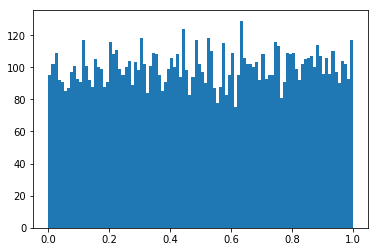

In [6]:
beta = torch.distributions.beta.Beta(torch.tensor([0.0001]), torch.tensor([0.0001]))
beta = torch.distributions.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
plt.hist(beta.sample([10000]).numpy()[:, 0], bins=100)
plt.show()

In [7]:
widths = [30] * 10
base = CPPNNet(widths, output_channels=widths[-1], input_channels=4)
viz = UpsampleNet(base, reps=1).to(device)

In [8]:
c = 1.0
skip = 5
# FEATURE_CHANNEL = 30
FEATURE_CHANNEL = 43
def imgnet_objective(output, alpha):
    r = model((output - mean) / std)
#     return torch.mean((r - targ) ** 2
#     alpha, beta = alpha
#     loss = (alpha * -r[:, FEATURE_CHANNEL]).mean() + ((1 - alpha) * -r[:, FEATURE_CHANNEL + 2]).mean()
#     loss += (beta * -r[:, FEATURE_CHANNEL + 6]).mean() + ((1 - beta) * -r[:, FEATURE_CHANNEL + 5]).mean()
    
    sel = torch.LongTensor([FEATURE_CHANNEL + i for i in range(0, 4 * skip, skip)])
    loss = -r[:, sel] * ((alpha.unsqueeze(2) * (1-alpha).unsqueeze(1)).view(alpha.shape[0], -1))
    loss = loss.mean()
    
#     loss = -r[:, FEATURE_CHANNEL].mean()
    return loss

size = [59, 105]
xy = get_xy_mesh(size).to(device)
def im_gen_fn(pct_done=0.0, num=16):
    xy_crop = []
    for i in range(num):
        x0 = np.random.randint(0, 105 - 59)
        xy_crop.append(xy[:, :, :, x0:x0 + 59])
    xy_crop = torch.cat(xy_crop, 0)
    r = beta.sample([xy_crop.shape[0], 2])[..., -1].to(device)
    alpha = r.round()  # 16, 2
    other = r * c * 2.0 - 1.0 * c
    other = other.view(xy_crop.shape[0], 2, 1, 1).repeat([1, 1, xy_crop.shape[2], xy_crop.shape[3]])
    xy_crop = torch.cat([xy_crop, other], 1)
    return viz(xy_crop), alpha

In [9]:
opt = optim.Adam(viz.parameters(), lr=0.002)
div = 5

  0%|          | 0/300 [00:00<?, ?it/s]/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


cost -0.01802498660981655


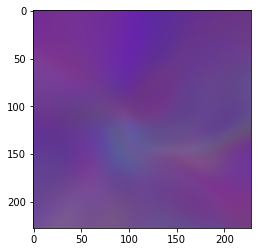

  3%|▎         | 10/300 [00:02<01:12,  4.02it/s]

cost -0.06269724667072296


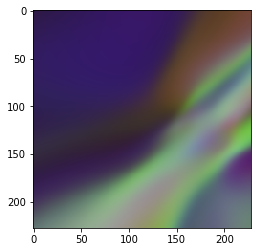

  7%|▋         | 20/300 [00:04<01:08,  4.07it/s]

cost -0.0876171663403511


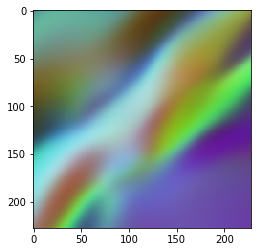

 10%|█         | 30/300 [00:07<01:06,  4.05it/s]

cost -0.13766570389270782


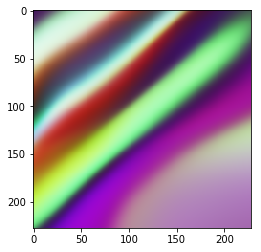

 13%|█▎        | 40/300 [00:10<01:04,  4.05it/s]

cost -0.08506964147090912


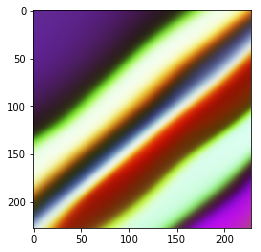

 17%|█▋        | 50/300 [00:12<01:01,  4.05it/s]

cost -0.09026651084423065


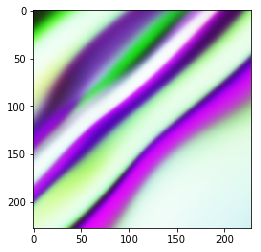

 20%|██        | 60/300 [00:15<00:59,  4.05it/s]

cost -0.16043660044670105


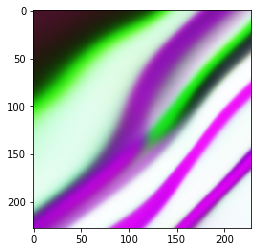

 23%|██▎       | 70/300 [00:17<00:56,  4.04it/s]

cost -0.08645238727331161


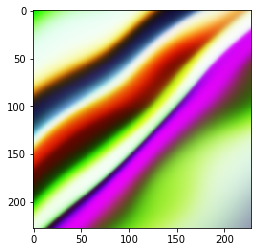

 27%|██▋       | 80/300 [00:20<00:54,  4.04it/s]

cost -0.14981406927108765


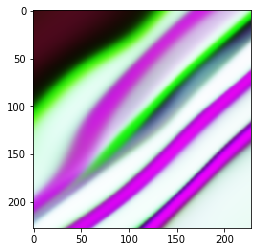

 30%|███       | 90/300 [00:23<00:52,  4.02it/s]

cost -0.2359149158000946


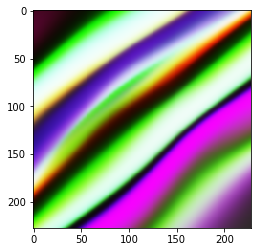

 33%|███▎      | 100/300 [00:25<00:49,  4.01it/s]

cost -0.1643633097410202


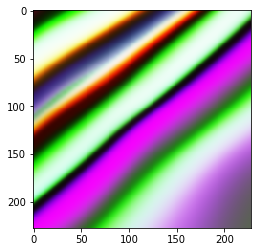

 37%|███▋      | 110/300 [00:28<00:47,  4.02it/s]

cost -0.09061239659786224


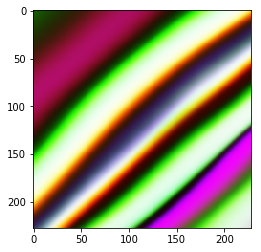

 40%|████      | 120/300 [00:31<00:44,  4.03it/s]

cost -0.1316901594400406


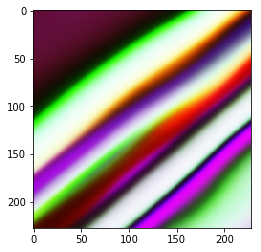

 43%|████▎     | 130/300 [00:33<00:42,  4.00it/s]

cost -0.16496843099594116


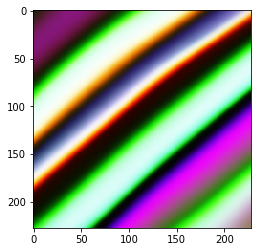

 47%|████▋     | 140/300 [00:36<00:40,  3.95it/s]

cost -0.12211331725120544


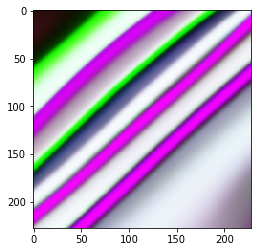

 50%|█████     | 150/300 [00:38<00:38,  3.94it/s]

cost -0.20776446163654327


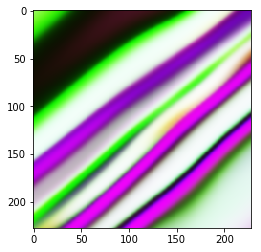

 53%|█████▎    | 160/300 [00:41<00:36,  3.88it/s]

cost -0.17578846216201782


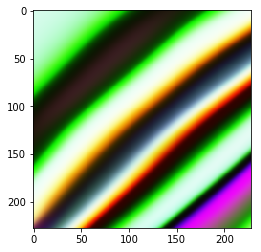

 57%|█████▋    | 170/300 [00:44<00:33,  3.87it/s]

cost -0.19549721479415894


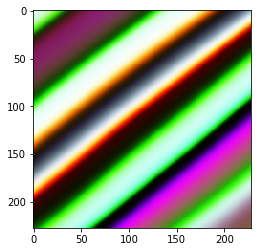

 60%|██████    | 180/300 [00:47<00:30,  3.87it/s]

cost -0.13837432861328125


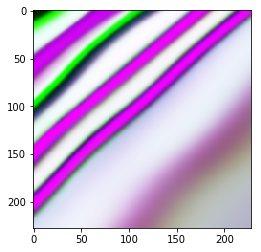

 63%|██████▎   | 190/300 [00:49<00:28,  3.84it/s]

cost -0.15987035632133484


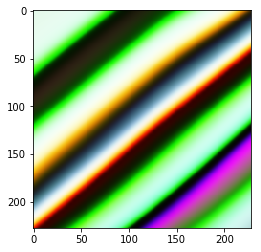

 67%|██████▋   | 200/300 [00:52<00:25,  3.86it/s]

cost -0.10261717438697815


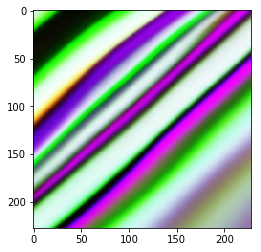

 70%|███████   | 210/300 [00:55<00:23,  3.82it/s]

cost -0.1753331422805786


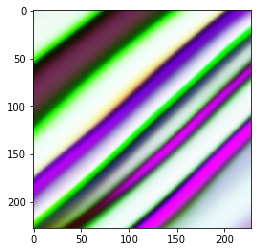

 73%|███████▎  | 220/300 [00:58<00:20,  3.81it/s]

cost -0.2149983048439026


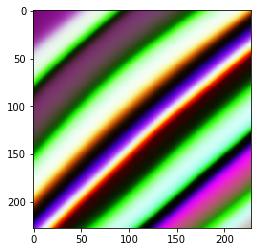

 77%|███████▋  | 230/300 [01:00<00:18,  3.79it/s]

cost -0.11436634510755539


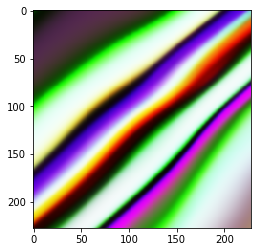

 80%|████████  | 240/300 [01:03<00:15,  3.85it/s]

cost -0.21726784110069275


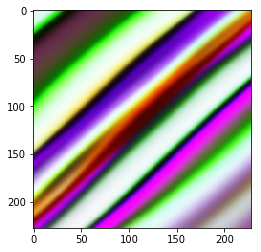

 83%|████████▎ | 250/300 [01:06<00:13,  3.77it/s]

cost -0.08499699085950851


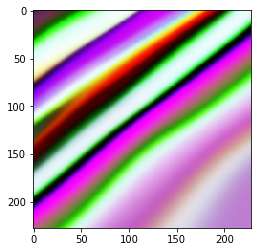

 87%|████████▋ | 260/300 [01:09<00:10,  3.73it/s]

cost -0.2137080281972885


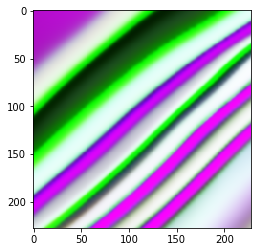

 90%|█████████ | 270/300 [01:12<00:07,  3.75it/s]

cost -0.20771996676921844


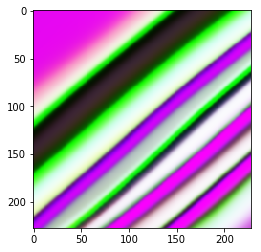

 93%|█████████▎| 280/300 [01:14<00:05,  3.70it/s]

cost -0.19919200241565704


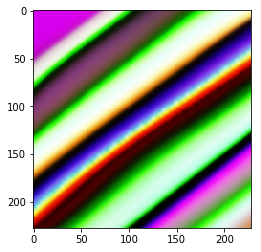

 97%|█████████▋| 290/300 [01:17<00:02,  3.74it/s]

cost -0.12666098773479462


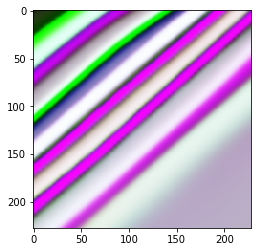

100%|██████████| 300/300 [01:20<00:00,  3.69it/s]


In [10]:
train_visualiser(imgnet_objective, im_gen_fn, opt, iters=30*50//div, log_interval=50//div)

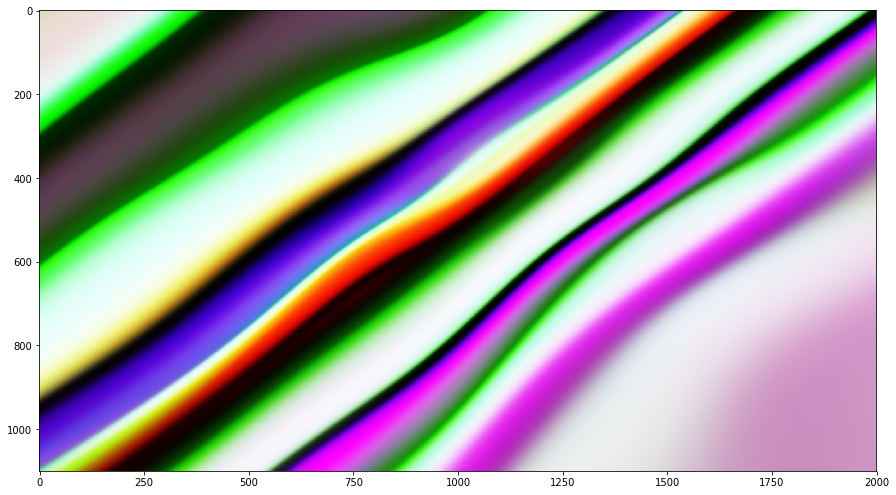

In [11]:
xy_big = get_xy_mesh([277, 502]).to(device)
other = torch.ones([xy_big.shape[0], 2]).to(device) * 2.0 * c - 1.0 * c
other = other.view(xy_big.shape[0], 2, 1, 1).repeat([1, 1, xy_big.shape[2], xy_big.shape[3]])
xy_big = torch.cat([xy_big, other], 1)
res = viz(xy_big)
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

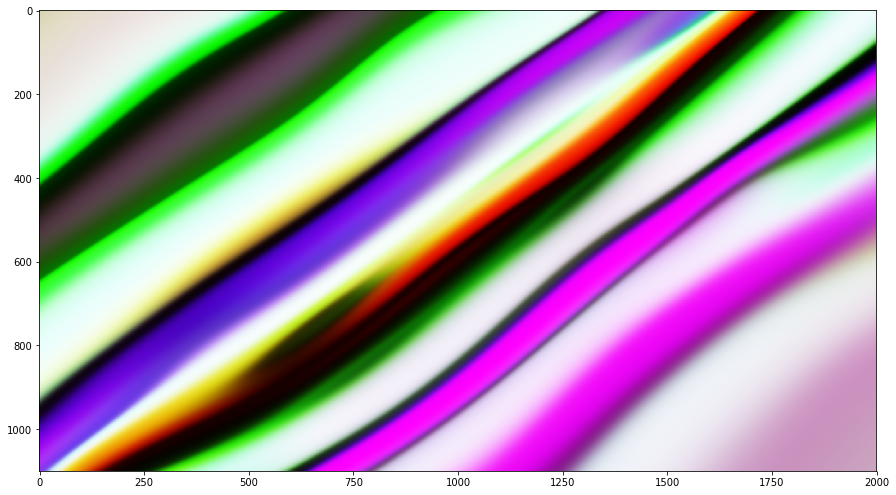

In [12]:
xy_big = get_xy_mesh([277, 502]).to(device)
other = torch.zeros([xy_big.shape[0], 2]).to(device) * 2.0 * c - 1.0 * c
other = other.view(xy_big.shape[0], 2, 1, 1).repeat([1, 1, xy_big.shape[2], xy_big.shape[3]])
xy_big = torch.cat([xy_big, other], 1)
res = viz(xy_big)
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

In [13]:
class Wrapper(nn.Module):
    def __init__(self, m):
        super(Wrapper, self).__init__()
        self.m = m

    def forward(self, x, o):
        o = o.view([1, 2, 1, 1])
        o = o.repeat([x.size(0), 1, x.size(2), x.size(3)])
        x = torch.cat([x, o], 1)
        x = self.m(x)
        x = torch.cat([x, torch.ones([x.size(0), 1, x.size(2), x.size(3)]).to(x.device)], 1)
        return x.permute(0, 3, 2, 1)

x, o = get_xy_mesh([200, 200]), torch.FloatTensor([0.3, 0.4])
[x, o] = [i.to(device) for i in [x, o]]
cppn_trace = torch.jit.trace(Wrapper(viz), (x, o))
torch.jit.save(cppn_trace, '/home/liam/cppns/{}.pth'.format)

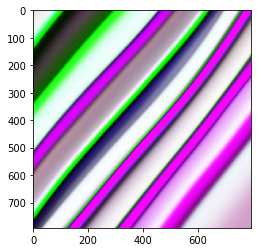

In [14]:
x, o = get_xy_mesh([200, 200]), torch.FloatTensor([-0.3, 0.4])
[x, o] = [i.to(device) for i in [x, o]]
outp = cppn_trace(x, o).to(device)
plt.imshow(outp.detach().cpu().numpy()[0])
plt.show()